In [299]:
import pdftotext
import logging  # Setting up the loggings to monitor gensim
import re
import spacy
from time import time
from gensim.models import Word2Vec
import multiprocessing
import nltk
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict  # For word frequency
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
import itertools

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

### Q1 - Reading,preprocessing and training

In [300]:
# Load your PDF
with open("The_Song_of_Ice_and_Fire_Series.pdf", "rb") as f:
    pdf = pdftotext.PDF(f)


In [301]:
#Keeping the data together in a list. Get the data from page 13 as we have the story starting from page 13
mydata=[]

for page in range(13,len(pdf)):
    clean_data=[re.sub('\s+',' ',data.strip()) for data in pdf[page].split('\n')]
    mydata.extend(clean_data)

In [302]:
mydata=' '.join(mydata)
mydata=nltk.sent_tokenize(mydata)

In [303]:
mydata[:20]

['PROLOGUE “W e should start back,” Gared urged as the woods began to grow dark around them.',
 '“The wildlings are dead.” “Do the dead frighten you?” Ser Waymar Royce asked with just the hint of a smile.',
 'Gared did not rise to the bait.',
 'He was an old man, past fifty, and he had seen the lordlings come and go.',
 '“Dead is dead,” he said.',
 '“We have no business with the dead.” “Are they dead?” Royce asked softly.',
 '“What proof have we?” “Will saw them,” Gared said.',
 '“If he says they are dead, that’s proof enough for me.” Will had known they would drag him into the quarrel sooner or later.',
 'He wished it had been later rather than sooner.',
 '“My mother told me that dead men sing no songs,” he put in.',
 '“My wet nurse said the same thing, Will,” Royce replied.',
 '“Never believe anything you hear at a woman’s tit.',
 'There are things to be learned even from the dead.” His voice echoed, too loud in the twilit forest.',
 '“We have a long ride before us,” Gared pointed ou

In [304]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if token.lemma_!='-PRON-']
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt).strip()

In [305]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in mydata)

In [306]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
#txt=[i for i in txt if i]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.04 mins


In [307]:
txt[:10]

['prologue w e should start back gare urge as the wood begin to grow dark around',
 'the wildling be dead do the dead frighten ser waymar royce ask with just the hint of a smile',
 'gared do not rise to the bait',
 'be an old man past fifty and have see the lordling come and go',
 'dead be dead say',
 'have no business with the dead be dead royce ask softly',
 'what proof have will saw gare say',
 'if say be dead that s proof enough for will have know would drag into the quarrel sooner or later',
 'wish have be later rather than sooner',
 'mother tell that dead man sing no song put in']

### Model

In [308]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [309]:
cores

12

In [310]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [311]:
t = time()

new=[nltk.word_tokenize(i) for i in txt if i]

w2v_model.build_vocab(new, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 19:30:20: collecting all words and their counts
INFO - 19:30:20: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:30:20: PROGRESS: at sentence #10000, processed 133611 words, keeping 6192 word types
INFO - 19:30:20: PROGRESS: at sentence #20000, processed 273604 words, keeping 8418 word types
INFO - 19:30:20: PROGRESS: at sentence #30000, processed 413192 words, keeping 10200 word types
INFO - 19:30:20: PROGRESS: at sentence #40000, processed 548447 words, keeping 11278 word types
INFO - 19:30:20: PROGRESS: at sentence #50000, processed 688339 words, keeping 12381 word types
INFO - 19:30:20: PROGRESS: at sentence #60000, processed 819792 words, keeping 13220 word types
INFO - 19:30:20: PROGRESS: at sentence #70000, processed 954389 words, keeping 13991 word types
INFO - 19:30:20: PROGRESS: at sentence #80000, processed 1083304 words, keeping 14739 word types
INFO - 19:30:20: collected 15521 word types from a corpus of 1224663 raw words and 89995 senten

Time to build vocab: 0.14 mins


In [312]:
t = time()

w2v_model.train(new, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 19:30:20: training model with 11 workers on 3692 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:30:21: worker thread finished; awaiting finish of 10 more threads
INFO - 19:30:21: worker thread finished; awaiting finish of 9 more threads
INFO - 19:30:21: worker thread finished; awaiting finish of 8 more threads
INFO - 19:30:21: worker thread finished; awaiting finish of 7 more threads
INFO - 19:30:21: worker thread finished; awaiting finish of 6 more threads
INFO - 19:30:21: worker thread finished; awaiting finish of 5 more threads
INFO - 19:30:21: worker thread finished; awaiting finish of 4 more threads
INFO - 19:30:21: worker thread finished; awaiting finish of 3 more threads
INFO - 19:30:21: worker thread finished; awaiting finish of 2 more threads
INFO - 19:30:21: worker thread finished; awaiting finish of 1 more threads
INFO - 19:30:21: worker thread finished; awaiting finish of 0 more threads
INFO - 19:30:21: EPOCH - 1 : training o

INFO - 19:30:27: worker thread finished; awaiting finish of 3 more threads
INFO - 19:30:27: worker thread finished; awaiting finish of 2 more threads
INFO - 19:30:27: worker thread finished; awaiting finish of 1 more threads
INFO - 19:30:27: worker thread finished; awaiting finish of 0 more threads
INFO - 19:30:27: EPOCH - 9 : training on 1224663 raw words (415306 effective words) took 0.8s, 545755 effective words/s
INFO - 19:30:28: worker thread finished; awaiting finish of 10 more threads
INFO - 19:30:28: worker thread finished; awaiting finish of 9 more threads
INFO - 19:30:28: worker thread finished; awaiting finish of 8 more threads
INFO - 19:30:28: worker thread finished; awaiting finish of 7 more threads
INFO - 19:30:28: worker thread finished; awaiting finish of 6 more threads
INFO - 19:30:28: worker thread finished; awaiting finish of 5 more threads
INFO - 19:30:28: worker thread finished; awaiting finish of 4 more threads
INFO - 19:30:28: worker thread finished; awaiting fini

INFO - 19:30:34: worker thread finished; awaiting finish of 7 more threads
INFO - 19:30:34: worker thread finished; awaiting finish of 6 more threads
INFO - 19:30:34: worker thread finished; awaiting finish of 5 more threads
INFO - 19:30:34: worker thread finished; awaiting finish of 4 more threads
INFO - 19:30:34: worker thread finished; awaiting finish of 3 more threads
INFO - 19:30:34: worker thread finished; awaiting finish of 2 more threads
INFO - 19:30:34: worker thread finished; awaiting finish of 1 more threads
INFO - 19:30:34: worker thread finished; awaiting finish of 0 more threads
INFO - 19:30:34: EPOCH - 18 : training on 1224663 raw words (414646 effective words) took 0.8s, 547288 effective words/s
INFO - 19:30:35: worker thread finished; awaiting finish of 10 more threads
INFO - 19:30:35: worker thread finished; awaiting finish of 9 more threads
INFO - 19:30:35: worker thread finished; awaiting finish of 8 more threads
INFO - 19:30:35: worker thread finished; awaiting fin

INFO - 19:30:41: worker thread finished; awaiting finish of 10 more threads
INFO - 19:30:41: worker thread finished; awaiting finish of 9 more threads
INFO - 19:30:41: worker thread finished; awaiting finish of 8 more threads
INFO - 19:30:41: worker thread finished; awaiting finish of 7 more threads
INFO - 19:30:41: worker thread finished; awaiting finish of 6 more threads
INFO - 19:30:41: worker thread finished; awaiting finish of 5 more threads
INFO - 19:30:41: worker thread finished; awaiting finish of 4 more threads
INFO - 19:30:41: worker thread finished; awaiting finish of 3 more threads
INFO - 19:30:41: worker thread finished; awaiting finish of 2 more threads
INFO - 19:30:41: worker thread finished; awaiting finish of 1 more threads
INFO - 19:30:41: worker thread finished; awaiting finish of 0 more threads
INFO - 19:30:41: EPOCH - 27 : training on 1224663 raw words (414618 effective words) took 0.8s, 542966 effective words/s
INFO - 19:30:42: worker thread finished; awaiting fin

Time to train the model: 0.38 mins


In [313]:
w2v_model.init_sims(replace=True)

INFO - 19:30:43: precomputing L2-norms of word weight vectors


In [314]:
w2v_model.wv.most_similar(positive=["targaryen"])

[('ii', 0.7036667466163635),
 ('stormborn', 0.6150925159454346),
 ('jaehaerys', 0.598471999168396),
 ('aegon', 0.5306622982025146),
 ('conqueror', 0.522280216217041),
 ('daeron', 0.5144698619842529),
 ('conquest', 0.4822579622268677),
 ('reign', 0.4818761944770813),
 ('viserys', 0.47803646326065063),
 ('rhaenys', 0.4670172929763794)]

That looks like a bunch of targaryen family coming together

### Q2- Bigram training

In [318]:
##let's use phrases from gensim model to address the bigram issue
phrases = Phrases(new, min_count=5, progress_per=10000)

INFO - 19:32:17: collecting all words and their counts
INFO - 19:32:17: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:32:18: PROGRESS: at sentence #10000, processed 133611 words and 63384 word types
INFO - 19:32:18: PROGRESS: at sentence #20000, processed 273604 words and 107055 word types
INFO - 19:32:18: PROGRESS: at sentence #30000, processed 413192 words and 146438 word types
INFO - 19:32:18: PROGRESS: at sentence #40000, processed 548447 words and 179178 word types
INFO - 19:32:18: PROGRESS: at sentence #50000, processed 688339 words and 210897 word types
INFO - 19:32:18: PROGRESS: at sentence #60000, processed 819792 words and 238480 word types
INFO - 19:32:18: PROGRESS: at sentence #70000, processed 954389 words and 264332 word types
INFO - 19:32:19: PROGRESS: at sentence #80000, processed 1083304 words and 288898 word types
INFO - 19:32:19: collected 315113 word types from a corpus of 1224663 words (unigram + bigrams) and 89995 sentences
INFO - 19:32:19

In [319]:
bigram = Phraser(phrases)

INFO - 19:32:19: source_vocab length 315113
INFO - 19:32:21: Phraser built with 1920 phrasegrams


In [320]:
sentences = bigram[new]

In [321]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

17305

In [322]:
t = time()

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 19:32:24: collecting all words and their counts
INFO - 19:32:24: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:32:24: PROGRESS: at sentence #10000, processed 128450 words, keeping 7063 word types
INFO - 19:32:25: PROGRESS: at sentence #20000, processed 262583 words, keeping 9626 word types
INFO - 19:32:25: PROGRESS: at sentence #30000, processed 396799 words, keeping 11568 word types
INFO - 19:32:25: PROGRESS: at sentence #40000, processed 527045 words, keeping 12742 word types
INFO - 19:32:26: PROGRESS: at sentence #50000, processed 661027 words, keeping 13947 word types
INFO - 19:32:26: PROGRESS: at sentence #60000, processed 787247 words, keeping 14849 word types
INFO - 19:32:26: PROGRESS: at sentence #70000, processed 916030 words, keeping 15676 word types
INFO - 19:32:27: PROGRESS: at sentence #80000, processed 1040132 words, keeping 16489 word types
INFO - 19:32:27: collected 17305 word types from a corpus of 1175710 raw words and 89995 senten

Time to build vocab: 0.06 mins


In [323]:
t = time()

w2v_model.train(new, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 19:32:28: training model with 11 workers on 3954 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:32:28: worker thread finished; awaiting finish of 10 more threads
INFO - 19:32:28: worker thread finished; awaiting finish of 9 more threads
INFO - 19:32:28: worker thread finished; awaiting finish of 8 more threads
INFO - 19:32:28: worker thread finished; awaiting finish of 7 more threads
INFO - 19:32:28: worker thread finished; awaiting finish of 6 more threads
INFO - 19:32:28: worker thread finished; awaiting finish of 5 more threads
INFO - 19:32:28: worker thread finished; awaiting finish of 4 more threads
INFO - 19:32:28: worker thread finished; awaiting finish of 3 more threads
INFO - 19:32:28: worker thread finished; awaiting finish of 2 more threads
INFO - 19:32:28: worker thread finished; awaiting finish of 1 more threads
INFO - 19:32:28: worker thread finished; awaiting finish of 0 more threads
INFO - 19:32:28: EPOCH - 1 : training o

INFO - 19:32:34: worker thread finished; awaiting finish of 3 more threads
INFO - 19:32:34: worker thread finished; awaiting finish of 2 more threads
INFO - 19:32:34: worker thread finished; awaiting finish of 1 more threads
INFO - 19:32:34: worker thread finished; awaiting finish of 0 more threads
INFO - 19:32:34: EPOCH - 9 : training on 1224663 raw words (415920 effective words) took 0.7s, 577934 effective words/s
INFO - 19:32:35: worker thread finished; awaiting finish of 10 more threads
INFO - 19:32:35: worker thread finished; awaiting finish of 9 more threads
INFO - 19:32:35: worker thread finished; awaiting finish of 8 more threads
INFO - 19:32:35: worker thread finished; awaiting finish of 7 more threads
INFO - 19:32:35: worker thread finished; awaiting finish of 6 more threads
INFO - 19:32:35: worker thread finished; awaiting finish of 5 more threads
INFO - 19:32:35: worker thread finished; awaiting finish of 4 more threads
INFO - 19:32:35: worker thread finished; awaiting fini

INFO - 19:32:41: worker thread finished; awaiting finish of 7 more threads
INFO - 19:32:41: worker thread finished; awaiting finish of 6 more threads
INFO - 19:32:41: worker thread finished; awaiting finish of 5 more threads
INFO - 19:32:41: worker thread finished; awaiting finish of 4 more threads
INFO - 19:32:41: worker thread finished; awaiting finish of 3 more threads
INFO - 19:32:41: worker thread finished; awaiting finish of 2 more threads
INFO - 19:32:41: worker thread finished; awaiting finish of 1 more threads
INFO - 19:32:41: worker thread finished; awaiting finish of 0 more threads
INFO - 19:32:41: EPOCH - 18 : training on 1224663 raw words (415369 effective words) took 0.8s, 544627 effective words/s
INFO - 19:32:42: worker thread finished; awaiting finish of 10 more threads
INFO - 19:32:42: worker thread finished; awaiting finish of 9 more threads
INFO - 19:32:42: worker thread finished; awaiting finish of 8 more threads
INFO - 19:32:42: worker thread finished; awaiting fin

INFO - 19:32:48: worker thread finished; awaiting finish of 10 more threads
INFO - 19:32:48: worker thread finished; awaiting finish of 9 more threads
INFO - 19:32:48: worker thread finished; awaiting finish of 8 more threads
INFO - 19:32:48: worker thread finished; awaiting finish of 7 more threads
INFO - 19:32:48: worker thread finished; awaiting finish of 6 more threads
INFO - 19:32:48: worker thread finished; awaiting finish of 5 more threads
INFO - 19:32:48: worker thread finished; awaiting finish of 4 more threads
INFO - 19:32:48: worker thread finished; awaiting finish of 3 more threads
INFO - 19:32:48: worker thread finished; awaiting finish of 2 more threads
INFO - 19:32:48: worker thread finished; awaiting finish of 1 more threads
INFO - 19:32:48: worker thread finished; awaiting finish of 0 more threads
INFO - 19:32:48: EPOCH - 27 : training on 1224663 raw words (416248 effective words) took 0.7s, 556836 effective words/s
INFO - 19:32:49: worker thread finished; awaiting fin

Time to train the model: 0.38 mins


In [324]:
w2v_model.init_sims(replace=True)

INFO - 19:32:51: precomputing L2-norms of word weight vectors


### Q3

In [333]:
w2v_model.wv.most_similar(positive=["casterly_rock"],topn=20)

[('uncle_benjen', 0.1644604653120041),
 ('shadow_tower', 0.16332247853279114),
 ('anyone', 0.1530953049659729),
 ('loras_tyrell', 0.15228307247161865),
 ('direction', 0.14660164713859558),
 ('anything', 0.14459127187728882),
 ('detail', 0.1424148976802826),
 ('freedman', 0.1421726793050766),
 ('traveler', 0.13949556648731232),
 ('state', 0.13864624500274658),
 ('clearly', 0.1379716992378235),
 ('jaime_lannister', 0.1373881697654724),
 ('seem', 0.13717390596866608),
 ('crossroad', 0.13395540416240692),
 ('pit', 0.13387227058410645),
 ('common', 0.13253392279148102),
 ('village', 0.12748058140277863),
 ('have', 0.1262872815132141),
 ('year_old', 0.12593308091163635),
 ('uneasy', 0.12333676964044571)]

In [334]:
w2v_model.wv.similarity("stark", 'winterfell')

0.49967316

In [335]:
w2v_model.wv.most_similar(positive=["catelyn", "ned"], negative=["winterfell"], topn=3)

[('tyrion', 0.5135495662689209),
 ('ne', 0.44605743885040283),
 ('sansa', 0.4226187467575073)]

In [328]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

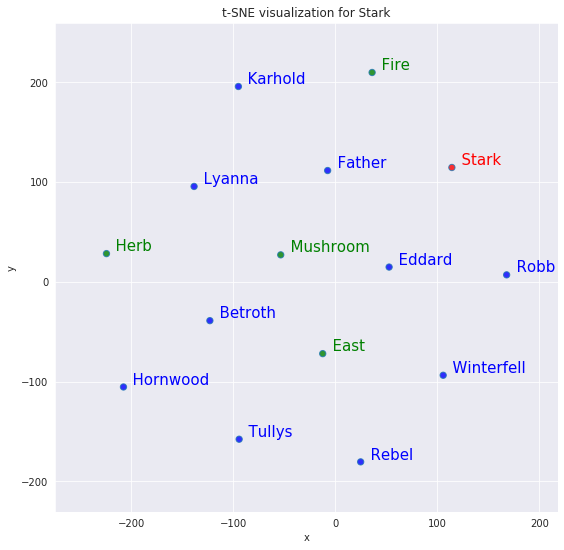

In [329]:
#plot of stark vs some random words

tsnescatterplot(w2v_model, 'stark', ['mushroom', 'east', 'herb', 'fire'])

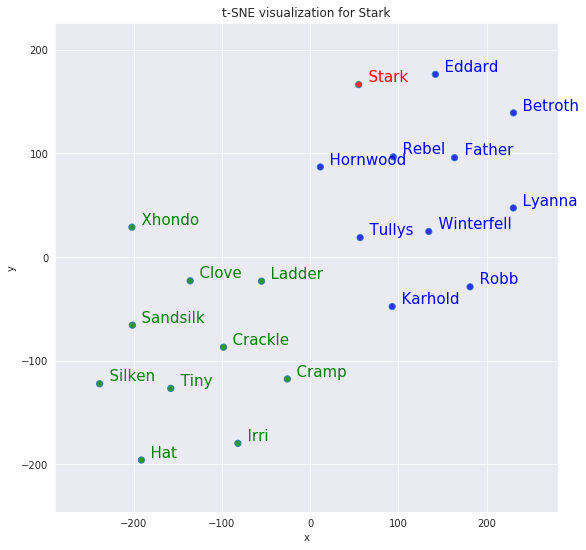

In [330]:
#plot of similar embeddings around stark and dissimilar embeddings for stark 
tsnescatterplot(w2v_model, 'stark', [i[0] for i in w2v_model.wv.most_similar(negative=["stark"])])

### Q4 - Different approaches for sentence embeddings 

### Mean of word embedding

In [336]:

class MeanEmbeddingVectorizer(object):

    def __init__(self, word_model):
        self.word_model = word_model
        self.vector_size = word_model.wv.vector_size

    def fit(self):  # comply with scikit-learn transformer requirement
        return self

    def transform(self, docs):  # comply with scikit-learn transformer requirement
        doc_word_vector = self.word_average_list(docs)
        return doc_word_vector

    def word_average(self, sent):
        """
        Compute average word vector for a single doc/sentence.
        :param sent: list of sentence tokens
        :return:
            mean: float of averaging word vectors
        """
        mean = []
        for word in sent:
            if word in self.word_model.wv.vocab:
                mean.append(self.word_model.wv.get_vector(word))

        if not mean:  # empty words
            # If a text is empty, return a vector of zeros.
            logging.warning("cannot compute average owing to no vector for {}".format(sent))
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean


    def word_average_list(self, docs):
        """
        Compute average word vector for multiple docs, where docs had been tokenized.
        :param docs: list of sentence in list of separated tokens
        :return:
            array of average word vector in shape (len(docs),)
        """
        return np.vstack([self.word_average(sent) for sent in docs])

In [337]:
mean_vec_tr = MeanEmbeddingVectorizer(w2v_model)
doc_vec = mean_vec_tr.transform([' '.join(i) for i in new[54:56]])

In [338]:
doc_vec.shape

(2, 300)

### TFIDF weighted mean embedding

In [339]:
class TfidfEmbeddingVectorizer(object):

    def __init__(self, word_model):

        self.word_model = word_model
        self.word_idf_weight = None
        self.vector_size = word_model.wv.vector_size

    def fit(self, docs):  # comply with scikit-learn transformer requirement
        """
        Fit in a list of docs, which had been preprocessed and tokenized,
        such as word bi-grammed, stop-words removed, lemmatized, part of speech filtered.
        Then build up a tfidf model to compute each word's idf as its weight.
        Noted that tf weight is already involved when constructing average word vectors, and thus omitted.
        :param
            pre_processed_docs: list of docs, which are tokenized
        :return:
            self
        """

        tfidf = TfidfVectorizer()
        tfidf.fit(docs)  # must be list of text string

        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)  # used as default value for defaultdict
        
        self.word_idf_weight = defaultdict(lambda: max_idf,
                           [(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()])
        return self


    def transform(self, docs):  # comply with scikit-learn transformer requirement
        doc_word_vector = self.word_average_list(docs)
        return doc_word_vector


    def word_average(self, sent):
        """
        Compute average word vector for a single doc/sentence.
        :param sent: list of sentence tokens
        :return:
            mean: float of averaging word vectors
        """

        mean = []
        for word in sent:
            if word in self.word_model.wv.vocab:
                mean.append(self.word_model.wv.get_vector(word) * self.word_idf_weight[word])  # idf weighted

        if not mean:  # empty words
            # If a text is empty, return a vector of zeros.
            logging.warning("cannot compute average owing to no vector for {}".format(sent))
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean


    def word_average_list(self, docs):
        """
        Compute average word vector for multiple docs, where docs had been tokenized.
        :param docs: list of sentence in list of separated tokens
        :return:
            array of average word vector in shape (len(docs),)
        """
        return np.vstack([self.word_average(sent) for sent in docs])

In [341]:
mean_vec_tr = TfidfEmbeddingVectorizer(w2v_model)
mean_vec_tr.fit([' '.join(i) for i in new[5:500]])
doc_vec = mean_vec_tr.transform([' '.join(i) for i in new[5:500]])

doc_vec.shape

(495, 300)

### SIF embedding

In [342]:
def map_word_frequency(document):
    return Counter(itertools.chain(*document))
    
def get_sif_feature_vectors(sentences, word_emb_model):
    
    sent=[]
    tokens=[]
    for sentence in sentences:
        sent.append([token for token in sentence.split() if token in word_emb_model.wv.vocab])
        tokens.extend([token for token in sentence.split() if token in word_emb_model.wv.vocab])
        
    word_counts = map_word_frequency(tokens)
    embedding_size = 300 # size of vectore in word embeddings
    a = 0.001
    sentence_set=[]
    for sentence in sent:
        vs = np.zeros(embedding_size)
        sentence_length = len(sentence)
        for word in sentence:
            a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, word_emb_model.wv[word])) # vs += sif * word_vector
        vs = np.divide(vs, sentence_length) # weighted average
        sentence_set.append(vs)
    return np.vstack(sentence_set)

In [343]:
get_sif_feature_vectors([' '.join(i) for i in new[5:500]],w2v_model).shape

(495, 300)